In [19]:
import sys
sys.path.append("/app/flow_matching")
from pathlib import Path
import json
from models.model_configs import instantiate_model
import torch
from training.eval_loop import CFGScaledModel
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver.ode_solver import ODESolver
from flow_matching.solver.discrete_solver import MixtureDiscreteEulerSolver
from matplotlib import pyplot as plt

In [20]:
# Substitute your pretrained checkpoint path
checkpoint_path = Path("/app/flow_matching/examples/image/output_dir/checkpoint-1799.pth")
args_filepath = checkpoint_path.parent / 'args.json'
with open(args_filepath, 'r') as f:
    args_dict = json.load(f)

model = instantiate_model(architechture=args_dict['dataset'], is_discrete='discrete_flow_matching' in args_dict  and args_dict['discrete_flow_matching'],
                          use_ema=args_dict['use_ema'])
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
model.load_state_dict(checkpoint["model"])
model.train(False)

device = 'cuda'
model.to(device=device)




In [21]:
print(json.dumps(args_dict, indent=4))

{
    "batch_size": 64,
    "epochs": 3000,
    "accum_iter": 1,
    "lr": 0.0001,
    "optimizer_betas": [
        0.9,
        0.95
    ],
    "decay_lr": false,
    "class_drop_prob": 1.0,
    "skewed_timesteps": true,
    "edm_schedule": true,
    "use_ema": true,
    "dataset": "cifar10",
    "data_path": "./data/image_generation",
    "output_dir": "./output_dir",
    "ode_method": "heun2",
    "ode_options": {
        "nfe": 50
    },
    "sym": 0.0,
    "temp": 1.0,
    "sym_func": false,
    "sampling_dtype": "float32",
    "cfg_scale": 0.0,
    "fid_samples": 50000,
    "device": "cuda",
    "seed": 0,
    "resume": "",
    "start_epoch": 0,
    "eval_only": false,
    "eval_frequency": 100,
    "compute_fid": true,
    "save_fid_samples": false,
    "num_workers": 10,
    "pin_mem": true,
    "world_size": 1,
    "local_rank": -1,
    "dist_on_itp": false,
    "dist_url": "env://",
    "test_run": false,
    "discrete_flow_matching": false,
    "discrete_fm_steps": 1024,
   

## Sampling

In [25]:
sample_resolution = 32
batch_size = args_dict['batch_size']cfg_weighted_model = CFGScaledModel(model=model)
x_0 = torch.randn([batch_size, 3, sample_resolution, sample_resolution], dtype=torch.float32, device=device)    
solver = ODESolver(velocity_model=cfg_weighted_model)
ode_opts = args_dict['ode_options']
ode_opts["method"] = args_dict['ode_method']
synthetic_samples = solver.sample(
    time_grid=torch.tensor([0.0, 1.0], device=device),
    x_init=x_0,
    method=args_dict['ode_method'],
    step_size=0.01,
    label=None,
    cfg_scale=args_dict['cfg_scale'],
)

synthetic_samples = torch.clamp(
    synthetic_samples * 0.5 + 0.5, min=0.0, max=1.0
)
synthetic_samples = torch.floor(synthetic_samples * 255) / 255.0

## Plotting the samples

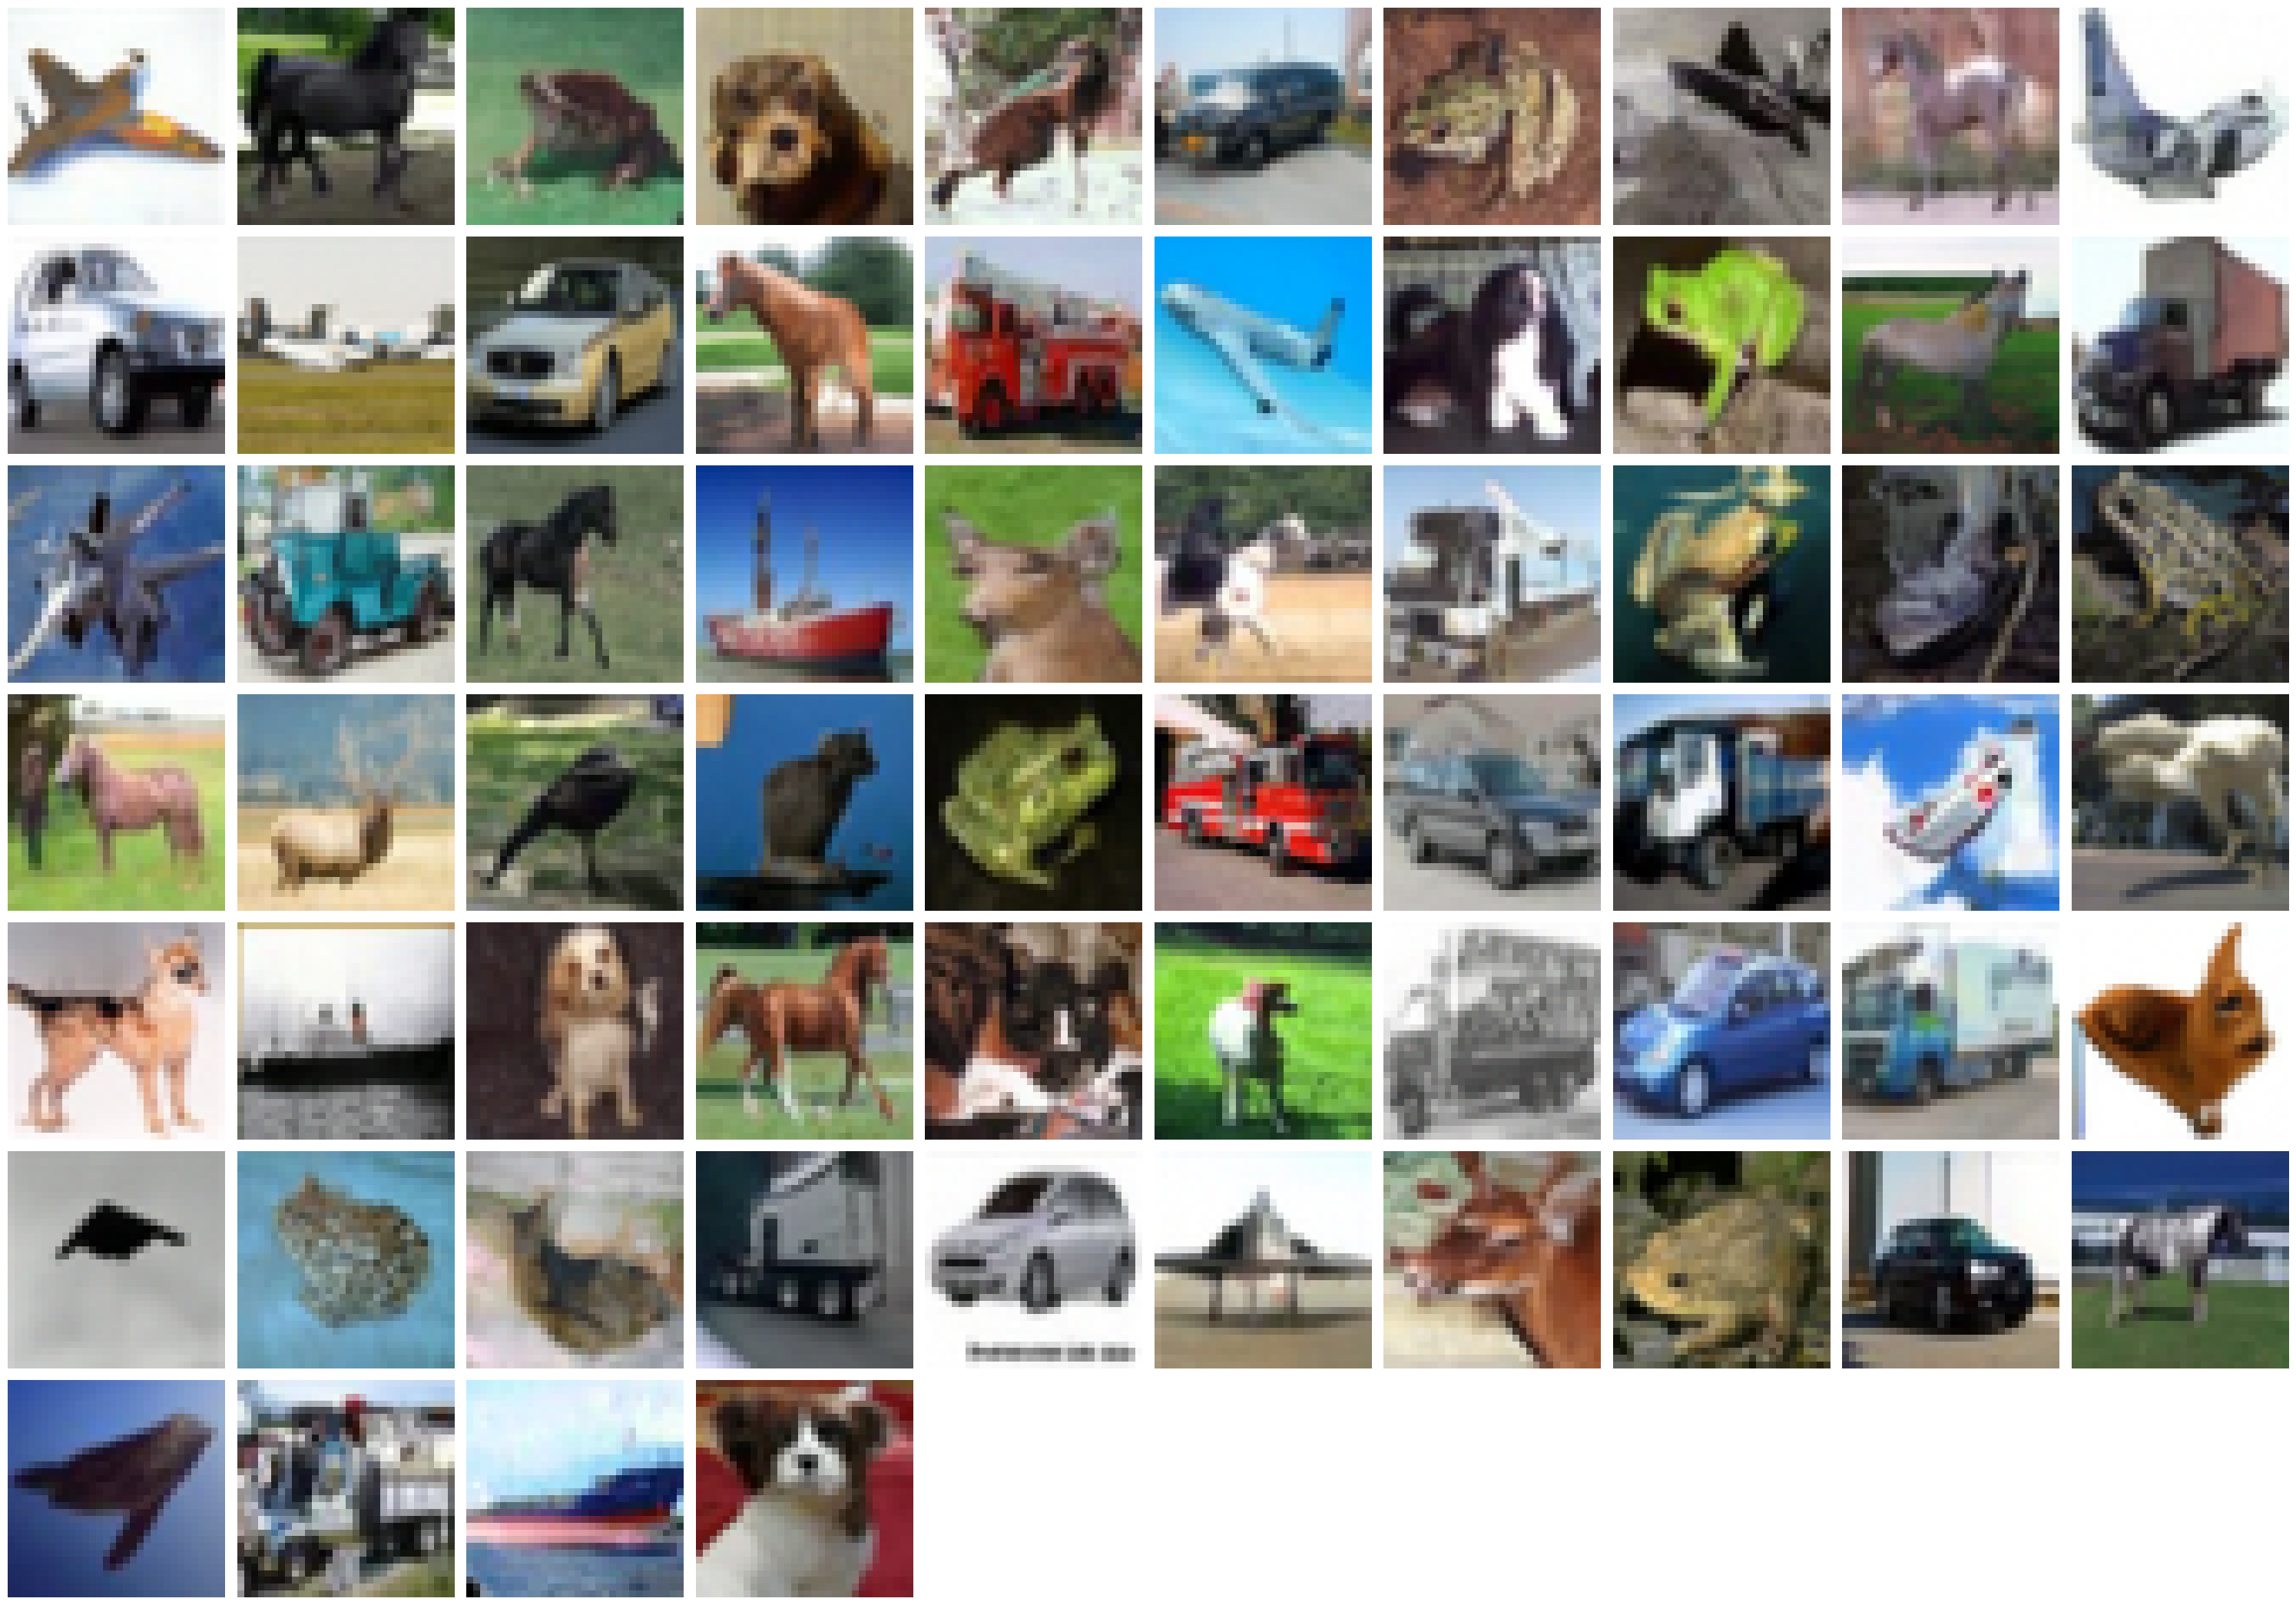

In [26]:
cols = 10
rows = (batch_size + cols - 1) // cols
plt.figure(figsize=(cols * 3, rows * 3))
for i in range(batch_size):
    image = synthetic_samples[i].cpu().permute(1, 2, 0).numpy()
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()